# 🎯 DCA Polymarket Backtesting v10

Works with pre-reconstructed orderbook parquet files (from `reconstruct_orderbooks.py`)

**Expected columns:** `datetime, asset_id, market_id, ob_best_bid, ob_best_ask, ob_mid_price, orderbook_bids, orderbook_asks`

## 1. Setup

In [59]:
import pandas as pd
import numpy as np
import json
import warnings
from typing import Dict, List, Optional, Tuple

warnings.filterwarnings('ignore')
print("✅ Imports ready")

✅ Imports ready


## 2. Core Functions

In [60]:
def parse_orderbook_levels(json_str: str) -> List[Dict]:
    """Parse orderbook levels from JSON string."""
    if not json_str or pd.isna(json_str):
        return []
    try:
        return json.loads(json_str)
    except:
        return []


def execute_buy(asks_json: str, amount_usd: float) -> Tuple[float, float, float]:
    """Execute buy against asks. Returns (shares, cost, avg_price)."""
    asks = parse_orderbook_levels(asks_json)
    if not asks or amount_usd <= 0:
        return 0, 0, 0
    
    shares, cost, remaining = 0, 0, amount_usd
    for level in asks:
        if remaining <= 0:
            break
        p, s = level['price'], level['size']
        take = min(s, remaining / p)
        shares += take
        cost += take * p
        remaining -= take * p
    
    return shares, cost, cost / shares if shares > 0 else 0


def execute_sell(bids_json: str, shares_to_sell: float) -> Tuple[float, float, float]:
    """Execute sell against bids. Returns (shares_sold, proceeds, avg_price)."""
    bids = parse_orderbook_levels(bids_json)
    if not bids or shares_to_sell <= 0:
        return 0, 0, 0
    
    sold, proceeds, remaining = 0, 0, shares_to_sell
    for level in bids:
        if remaining <= 0:
            break
        p, s = level['price'], level['size']
        take = min(s, remaining)
        sold += take
        proceeds += take * p
        remaining -= take
    
    return sold, proceeds, proceeds / sold if sold > 0 else 0


print("✅ Execution functions ready")

✅ Execution functions ready


In [61]:
DEFAULT_PARAMS = {
    'entry_threshold': 0.68,
    'exit_stop_loss': 0.50,
    'stop_loss_pct': 0.15,
    'take_profit_pct': 0.20,
    'dca_tier_1': 0.75,
    'dca_tier_2': 0.85,
    'dca_tier_3': 0.92,
    'weight_entry': 0.15,
    'weight_tier_1': 0.20,
    'weight_tier_2': 0.30,
    'weight_tier_3': 0.35,
    'cooldown_periods': 10,
}


def normalize_params(params: Dict) -> Dict:
    p = DEFAULT_PARAMS.copy()
    p.update(params or {})
    w_keys = ['weight_entry', 'weight_tier_1', 'weight_tier_2', 'weight_tier_3']
    total = sum(p[k] for k in w_keys)
    for k in w_keys:
        p[k] /= total
    return p


print("✅ Parameters ready")

✅ Parameters ready


## 3. Backtest Engine

In [62]:
def run_backtest(
    df: pd.DataFrame,
    params: Dict = None,
    known_winners: Dict = None,
    initial_capital: float = 500,
    global_tp_pct: float = 0.07,
    selected_markets: List = None,
    resample: str = False,
    verbose: bool = True
) -> Dict:
    """
    Run backtest on pre-reconstructed orderbook data.
    
    Args:
        df: DataFrame with ob_best_bid, ob_best_ask, orderbook_bids, orderbook_asks
        params: Strategy parameters
        known_winners: Dict of market_id -> winning asset_id
        initial_capital: Starting capital
        global_tp_pct: Global take profit percentage
        selected_markets: List of market indices or IDs (None = all)
        resample: Resample interval (e.g. '5s', '10s', None for no resample)
        verbose: Print progress
    """
    params = normalize_params(params)
    
    # Prepare data
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    
    # Filter to valid orderbook rows
    df = df[df['ob_best_bid'].notna() & df['ob_best_ask'].notna()].copy()
    
    # Market selection
    all_markets = df['market_id'].unique()
    if selected_markets is not None:
        sel = [all_markets[m] if isinstance(m, int) and m < len(all_markets) else m for m in selected_markets]
        df = df[df['market_id'].isin(sel)]
    
    if verbose:
        print(f"📊 {df['market_id'].nunique()} markets, {len(df):,} rows")
    
    # Resample
    if resample:
        df['bucket'] = df['datetime'].dt.floor(resample)
        df = df.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
        df = df.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})
        df = df.sort_values('datetime')
        if verbose:
            print(f"⏱️  Resampled to {resample}: {len(df):,} rows")
    else:
        if verbose:
            print(f"⏱️  No resampling: {len(df):,} rows")

    # Strategy params
    ENTRY = params['entry_threshold']
    EXIT_SL = params['exit_stop_loss']
    SL_PCT = params['stop_loss_pct']
    TP_PCT = params['take_profit_pct']
    COOLDOWN = params['cooldown_periods']
    GLOBAL_TP = initial_capital * global_tp_pct
    
    DCA_TIERS = [
        ('entry', ENTRY, params['weight_entry']),
        ('tier_1', params['dca_tier_1'], params['weight_tier_1']),
        ('tier_2', params['dca_tier_2'], params['weight_tier_2']),
        ('tier_3', params['dca_tier_3'], params['weight_tier_3']),
    ]
    
    # Initialize state
    markets = df['market_id'].unique()
    cap_per = initial_capital / len(markets)
    state = {
        m: {'alloc': cap_per, 'cash': cap_per, 'pos': {}, 'active': None, 
            'tiers': set(), 'pnl': 0, 'cooldown': {}, 'sl_count': 0, 'tp_count': 0}
        for m in markets
    }
    
    all_trades = []
    price_cache = {}
    global_tp_hit = False
    global_tp_ts = None
    
    # Main loop
    for _, row in df.iterrows():
        if global_tp_hit:
            break
        
        aid = row['asset_id']
        mid = row['market_id']
        ts = row['datetime']
        best_bid = row['ob_best_bid']
        best_ask = row['ob_best_ask']
        bids_json = row.get('orderbook_bids', '[]')
        asks_json = row.get('orderbook_asks', '[]')
        
        s = state[mid]
        price_cache[(mid, aid)] = (best_bid + best_ask) / 2
        has_pos = aid in s['pos'] and s['pos'][aid]['shares'] > 0
        
        # Global TP check
        total_pnl = sum(st['pnl'] for st in state.values())
        total_pnl += sum(
            price_cache.get((m, a), 0) * p['shares'] - p['cost']
            for m, st in state.items() for a, p in st['pos'].items() if p['shares'] > 0
        )
        
        if total_pnl >= GLOBAL_TP:
            global_tp_hit = True
            global_tp_ts = ts
            # Close all positions
            for m, st in state.items():
                for a, p in list(st['pos'].items()):
                    if p['shares'] > 0:
                        price = price_cache.get((m, a), 0)
                        proceeds = p['shares'] * price
                        pnl = proceeds - p['cost']
                        st['pnl'] += pnl
                        st['cash'] += proceeds
                        all_trades.append({'ts': ts, 'market': m, 'asset': a, 'action': 'SELL', 
                                          'reason': 'GLOBAL_TP', 'pnl': pnl})
                        p['shares'], p['cost'] = 0, 0
            break
        
        # Exit logic
        if has_pos:
            p = s['pos'][aid]
            avg = p['cost'] / p['shares']
            
            exit_reason = None
            if best_bid < EXIT_SL:
                exit_reason = 'STOP_LOSS_ABS'
            elif best_bid < avg * (1 - SL_PCT):
                exit_reason = 'STOP_LOSS_PCT'
            elif best_bid >= avg * (1 + TP_PCT):
                exit_reason = 'TAKE_PROFIT'
            
            if exit_reason:
                sold, proceeds, _ = execute_sell(bids_json, p['shares'])
                if sold > 0:
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds
                    s['pos'][aid] = {'shares': 0, 'cost': 0}
                    s['active'], s['tiers'] = None, set()
                    s['cooldown'][aid] = ts + pd.Timedelta(seconds=30 * COOLDOWN)
                    if 'STOP' in exit_reason:
                        s['sl_count'] += 1
                    else:
                        s['tp_count'] += 1
                    all_trades.append({'ts': ts, 'market': mid, 'asset': aid, 'action': 'SELL',
                                      'reason': exit_reason, 'pnl': pnl})
                continue
        
        # Cooldown check
        if aid in s['cooldown']:
            if ts < s['cooldown'][aid]:
                continue
            del s['cooldown'][aid]
        
        # Entry/DCA
        if best_ask >= ENTRY:
            if s['active'] is None:
                s['active'] = aid
            
            if s['active'] == aid:
                for tier, thresh, weight in DCA_TIERS:
                    if tier in s['tiers'] or best_ask < thresh:
                        continue
                    
                    amt = min(s['alloc'] * weight, s['cash'])
                    if amt <= 1:
                        continue
                    
                    shares, cost, avg_p = execute_buy(asks_json, amt)
                    if shares > 0:
                        if aid not in s['pos']:
                            s['pos'][aid] = {'shares': 0, 'cost': 0}
                        s['pos'][aid]['shares'] += shares
                        s['pos'][aid]['cost'] += cost
                        s['cash'] -= cost
                        s['tiers'].add(tier)
                        all_trades.append({'ts': ts, 'market': mid, 'asset': aid, 'action': 'BUY',
                                          'reason': tier, 'cost': cost, 'shares': shares})
                        break
    
    # Market close - settle remaining positions
    if not global_tp_hit:
        for mid, s in state.items():
            for aid, p in s['pos'].items():
                if p['shares'] > 0:
                    # Determine close price
                    if known_winners and mid in known_winners:
                        close_price = 1.0 if aid == known_winners[mid] else 0.0
                    else:
                        close_price = price_cache.get((mid, aid), 0.5)
                    
                    proceeds = p['shares'] * close_price
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds
                    all_trades.append({'market': mid, 'asset': aid, 'action': 'SELL',
                                      'reason': 'MARKET_CLOSE', 'pnl': pnl})
    
    # Results
    final_value = sum(s['cash'] for s in state.values())
    total_pnl = sum(s['pnl'] for s in state.values())
    wins = sum(1 for t in all_trades if t.get('pnl', 0) > 0)
    losses = sum(1 for t in all_trades if t.get('pnl', 0) < 0)
    
    results = {
        'total_return': (final_value - initial_capital) / initial_capital,
        'total_pnl': total_pnl,
        'final_value': final_value,
        'wins': wins,
        'losses': losses,
        'win_rate': wins / (wins + losses) if (wins + losses) > 0 else 0,
        'sl_count': sum(s['sl_count'] for s in state.values()),
        'tp_count': sum(s['tp_count'] for s in state.values()),
        'global_tp_hit': global_tp_hit,
        'global_tp_ts': global_tp_ts,
        'trades': pd.DataFrame(all_trades),
        'market_state': state,
        'params': params,
    }
    
    if verbose:
        print("\n" + "=" * 50)
        print("💰 RESULTS")
        print("=" * 50)
        print(f"Capital: ${initial_capital:.2f} → ${final_value:.2f} ({results['total_return']*100:+.1f}%)")
        print(f"P&L: ${total_pnl:+.2f} | Win Rate: {results['win_rate']*100:.0f}%")
        print(f"Wins: {wins} | Losses: {losses} | SL: {results['sl_count']} | TP: {results['tp_count']}")
        if global_tp_hit:
            print(f"🎯 Global TP hit at {global_tp_ts}")
        print("\n📋 Per Market:")
        for i, (m, s) in enumerate(state.items()):
            print(f"   {i}: ${s['pnl']:+.2f}")
    
    return results


print("✅ Backtest engine ready")

✅ Backtest engine ready


## 4. Utilities

In [63]:
def list_markets(df: pd.DataFrame):
    """Show available markets."""
    markets = df['market_id'].unique()
    print(f"\n📋 {len(markets)} Markets:")
    for i, m in enumerate(markets):
        n = len(df[df['market_id'] == m])
        print(f"  {i}: {m[:40]}... ({n:,} rows)")


print("✅ Utilities ready")

✅ Utilities ready


## 5. Known Winners

In [64]:
known_winners_24jan = {
    '0x88cb460d5214d9ef799a9a74941d2899fe15d427b15cbb24140328514b72ffab': '42781397119150928524620980569712935893636283323356676294919480802104602608040',
    '0xd32bca26a2e0691b235c19a79a7ab1893289be98e987a811cfadc9d927df9ccd': '91882959557077986206360079185370037618383834179859904199045807600717043152693',
    '0x6698f3324b7f643dfa2c9bcd2ecefa65935714b505eb5ee4ae15c139e48a3ea3': '13882206331450371303568000116534203832428526824407877756346123225263754654563',
    '0x188710cca5d961454b0173c03be5643b32bacb9a5cc1df7cccd5eb0958308808': '103069867371701144274707916726602160059633490990003222285779377518286262505715',
    '0xac2f84f4fd9252fd9d65badfcc30b5854018ab848c52ed220b108bf0c01a59e4': '100839774769010266331661617202208847432106473005501947665369602880398232703155',
}

known_winners_25jan = {
    '0x0ad7bfefa1318072a7718199b97c81e3815c013987400910ec4f341eab657163': '22548266195851269689477719506198642269528767995990837775232261605151563451942',
    '0x548bf24ac69dda721ac2c9f70ddf7d4907ddebfaa552b3c9d90c2ea579759850': '51674227959772201692995587953323756294034141098159045110117222361966129767794',
    '0x3b55b213f4d41ecf371a0308ea5e9bac95667b048828593908c5d6011f53c46f': '85996455898810555143401747386030485146842361772986418197315925327109740729086',
    '0xc71b8b2579a7b51d49cfda84312ae613ab5fca893659a0cc5d83116cdc689b35': '42126278325805086214134314057239966182355296066644260428412036278357258960610',
    '0x87d597755d0b8cb400ef7f1b2437a6ea5f84d25002951b676a1b783b26dad578': '17666858862007195233465506261917218863242430381450028132230016398149405665134',
}

known_winners_26jan = {
    '0xfa2de983f8642c0f61c6c9f6890144c00569720c7ac4966fa14ae61887805119': '100867343898929430052757546050745655715685585456696690891892865600379098158025',
    '0x31ab55ffa13f6db8e57d399ea90d4efa108e4ea3ebe8254b8dd711ce0300a44b': '87800006559503182362481555183568667613755424315939426292124794493674893045177',
    '0x0ec8aba4da6ff2d822375826e5b26a77ad44475880806e3911208676c8b27189': '50360611238162519349597526846658115119614668036291381303699223838097185992619',
    '0x1fc322c68723e7d66ccf795cdb8cf229ddb02e0e44b7d92e4d7818a6a8effab1': '12538008096049809260959942696355073549474960063955610419251367912602775702371',
    '0xfdc2ca60f0240b3d309dc2aa8fc80b30121003226490859114f2a544d295f9e1': '19370786313375349944222593512059669535964487521741074120538382195117540825433',
    '0x09aa5f4210ff3e17e65072e73bf084a1d72246ec712b8d33c4efbc958192a435': '112460056466301987895624067988030855175451380171501724318327858610989988015996',
}

known_winners_27jan = {
    '0xdc61b928589ea4d3e97bbb80a27e84eca4f59cfa9c37319ba2a7b63199bcdf31': '114810619020440066196286636298926087160454506616717843900975576221717806376761',
    '0xa338b21f43ccf35f427c9674a0effde074d28cabb7e2358ec498a1ba049b9470': '105917824473601761478847321769933632598106021887333748710627510244193706793258',
    '0xfbbca64429c68fe60f8b7f5713cb7c2b6e3f0b72ad72ead6e30c7bd7f03d2328': '114403476857604701724608088874049221045243705059599768206726165533185920136385',
    '0x96efea44484d3752fa72dc3ca5987c2e16a006112dbbe0174730b8ad5932c98f': '518272430027893766986552798258835853433678957912568820764900306532617260527',
    '0xb358099a4d3cd1908fafa4ef492d131a4d30a41866b556ac65ea0db905ec78a1': '48924055834814888428606569679658798321783136070365706735814433351016547108906',
    '0x6cefa261bfbee131da94a3ca013886a58606ae27055175ee62910251cd9aa532': '81640735300133043464899322835663435037559272815252333754895208703479291308029',
    '0x4e99e7565b30f92229489999e659a3136632449d88fc011bd4e8cc06c484ccca': '87890321414384780337490094423156067406932290358906185528607515117644478595310',
    '0x538be58810bd07707c1e849da9b4de12dc6617739c2e87043ea9b7fb2b6266c3': '41247652063966004401306857419416685235874842651432515489339067969075836389387',
    '0xcbed61cd2f96e0137ad098dcd8941efedea6f2e304f8b786f2a177ffffa9328a': '27061289282536287632793183240411687357181345607670439418333463229431698897460',
    '0x42c36cff27c928a58f71626244fb1acebcfd963976972cc03dc46c809a8663da': '41882622457175161594434643470609594422739676193078727425608733682888208989127',
    '0xbf399bc9894b502586ad0ed7383fffcadb07c21c507fb2a84a991741763a8efc': '35923522612276750394651557626496020946647566899591212994355411047671496757110',
    '0xf6a808c701b3432667fc8f21b3fe05259264cb45276aa7fcd2a7d486bfaa3601': '88289804616935923809321119252865056808373694473082600665834909738008415308474',
    '0xa9c0c820fd79b4339ed4711288ce15236196a6015234350f42b37341e9094398': '91609514063242777856043730063938310894548353925882406409927495687846407164056',
    '0xf42921f761a9553b33c3bcfebc42f48218b9147cf33d137f8daf28da996d5642': '72061868768744363794309804812683635190849437054114408108529113134643926789227',
}

print("✅ Known winners ready")

✅ Known winners ready


## 6. Usage

In [65]:
# =============================================================================
# LOAD RECONSTRUCTED PARQUET
# =============================================================================

# df = pd.read_parquet('snapshots_25jan_reconstructed.parquet')
# print(f"✅ Loaded {len(df):,} rows")
# list_markets(df)

In [66]:
# =============================================================================
# PARAMETERS
# =============================================================================

my_params = {
    'entry_threshold': 0.85,
    'exit_stop_loss': 0.70,
    'stop_loss_pct': 0.15,
    'take_profit_pct': 0.15,
    'cooldown_periods': 7,
    'dca_tier_1': 0.87,
    'dca_tier_2': 0.92,
    'dca_tier_3': 0.96,
    'weight_entry': 0.18,
    'weight_tier_1': 0.19,
    'weight_tier_2': 0.20,
    'weight_tier_3': 0.25,
}

print("✅ Parameters set")

✅ Parameters set


In [67]:
df = pd.read_parquet('snapshots_25jan_reconstructed.parquet')
results = run_backtest(df, params=my_params, known_winners=known_winners_25jan)

📊 6 markets, 1,781,596 rows
⏱️  No resampling: 1,781,596 rows

💰 RESULTS
Capital: $500.00 → $499.01 (-0.2%)
P&L: $-0.99 | Win Rate: 38%
Wins: 5 | Losses: 8 | SL: 8 | TP: 0

📋 Per Market:
   0: $+8.44
   1: $-3.26
   2: $-15.12
   3: $+8.45
   4: $-8.44
   5: $+8.94


In [68]:
# =============================================================================
# RUN BACKTEST
# =============================================================================

# All markets:
# results = run_backtest(df, params=my_params, known_winners=known_winners_25jan)

# Single market:
# results = run_backtest(df, params=my_params, known_winners=known_winners_25jan, selected_markets=[0])

## 7. Visualization

In [69]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_backtest(df: pd.DataFrame, results: Dict, market_index: int = 0, figsize=(16, 8)):
    """
    Plot price development with entry/exit markers.
    
    Args:
        df: The dataframe used for backtest (with ob_best_bid, ob_best_ask)
        results: Output from run_backtest()
        market_index: Which market to plot (0, 1, 2, ...)
        figsize: Figure size
    """
    params = results.get('params', {})
    trades_df = results.get('trades', pd.DataFrame())
    market_state = results.get('market_state', {})
    
    # Get market ID
    markets = list(market_state.keys())
    if market_index >= len(markets):
        print(f"❌ Market index {market_index} out of range (max {len(markets)-1})")
        return
    
    market_id = markets[market_index]
    market_pnl = market_state[market_id]['pnl']
    
    # Filter data for this market
    mdf = df[df['market_id'] == market_id].copy()
    mdf['datetime'] = pd.to_datetime(mdf['datetime'])
    mdf = mdf.sort_values('datetime')
    
    # Filter trades for this market
    if len(trades_df) > 0 and 'market' in trades_df.columns:
        mtrades = trades_df[trades_df['market'] == market_id].copy()
    else:
        mtrades = pd.DataFrame()
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot price lines for each asset
    colors = {'asset1': '#2196F3', 'asset2': '#FF9800'}
    assets = mdf['asset_id'].unique()
    
    for i, asset_id in enumerate(assets):
        adf = mdf[mdf['asset_id'] == asset_id].sort_values('datetime')
        color = list(colors.values())[i % len(colors)]
        label = f'Asset {i+1}'
        
        # Plot mid price
        mid = (adf['ob_best_bid'] + adf['ob_best_ask']) / 2
        ax.plot(adf['datetime'], mid, color=color, alpha=0.7, linewidth=1.5, label=label)
        
        # Plot bid-ask spread as shaded area
        ax.fill_between(adf['datetime'], adf['ob_best_bid'], adf['ob_best_ask'], 
                       color=color, alpha=0.1)
    
    # Plot threshold lines
    if params:
        entry_thresh = params.get('entry_threshold', 0.68)
        exit_sl = params.get('exit_stop_loss', 0.50)
        
        ax.axhline(y=entry_thresh, color='green', linestyle='--', alpha=0.5, 
                   linewidth=1.5, label=f'Entry ({entry_thresh})')
        ax.axhline(y=exit_sl, color='red', linestyle='--', alpha=0.5, 
                   linewidth=1.5, label=f'Stop Loss ({exit_sl})')
        
        # DCA tier lines
        for tier in ['dca_tier_1', 'dca_tier_2', 'dca_tier_3']:
            if tier in params:
                ax.axhline(y=params[tier], color='gray', linestyle=':', alpha=0.3, linewidth=1)
    
    # Plot trade markers
    if len(mtrades) > 0 and 'ts' in mtrades.columns:
        # BUY markers - green triangles pointing up
        buys = mtrades[mtrades['action'] == 'BUY']
        if len(buys) > 0:
            for _, trade in buys.iterrows():
                ts = pd.to_datetime(trade['ts'])
                # Find price at that time
                closest = mdf.iloc[(mdf['datetime'] - ts).abs().argsort()[:1]]
                if len(closest) > 0:
                    price = (closest['ob_best_bid'].values[0] + closest['ob_best_ask'].values[0]) / 2
                    ax.scatter(ts, price, marker='^', s=150, c='green', edgecolors='darkgreen', 
                              linewidths=1.5, zorder=5)
                    # Add tier label
                    tier = trade.get('reason', '')
                    ax.annotate(tier, (ts, price), textcoords="offset points", 
                               xytext=(0, 10), ha='center', fontsize=8, color='green')
        
        # SELL markers - red/blue triangles pointing down
        sells = mtrades[mtrades['action'] == 'SELL']
        if len(sells) > 0:
            for _, trade in sells.iterrows():
                ts = trade.get('ts')
                if pd.isna(ts):
                    continue
                ts = pd.to_datetime(ts)
                # Find price at that time
                closest = mdf.iloc[(mdf['datetime'] - ts).abs().argsort()[:1]]
                if len(closest) > 0:
                    price = (closest['ob_best_bid'].values[0] + closest['ob_best_ask'].values[0]) / 2
                    pnl = trade.get('pnl', 0)
                    color = 'blue' if pnl > 0 else 'red'
                    edge = 'darkblue' if pnl > 0 else 'darkred'
                    ax.scatter(ts, price, marker='v', s=150, c=color, edgecolors=edge, 
                              linewidths=1.5, zorder=5)
                    # Add reason label
                    reason = trade.get('reason', '')
                    ax.annotate(f"{reason}\n${pnl:+.2f}", (ts, price), textcoords="offset points", 
                               xytext=(0, -20), ha='center', fontsize=7, color=color)
    
    # Formatting
    ax.set_xlabel('Time', fontsize=11)
    ax.set_ylabel('Price', fontsize=11)
    ax.set_title(f'Market {market_index + 1} | P&L: ${market_pnl:+.2f}\n{market_id[:50]}...', fontsize=12)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    
    # Grid and legend
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', fontsize=9)
    ax.set_ylim(0, 1.05)
    
    plt.tight_layout()
    plt.show()
    
    return fig


def plot_all_markets(df: pd.DataFrame, results: Dict, figsize=(16, 6)):
    """Plot all markets in the backtest."""
    market_state = results.get('market_state', {})
    n_markets = len(market_state)
    
    print(f"📊 Plotting {n_markets} markets...\n")
    
    for i in range(n_markets):
        plot_backtest(df, results, market_index=i, figsize=figsize)
        print()


print("✅ Visualization ready")
print("   plot_backtest(df, results, market_index=0)")
print("   plot_all_markets(df, results)")

✅ Visualization ready
   plot_backtest(df, results, market_index=0)
   plot_all_markets(df, results)


📊 Plotting 6 markets...



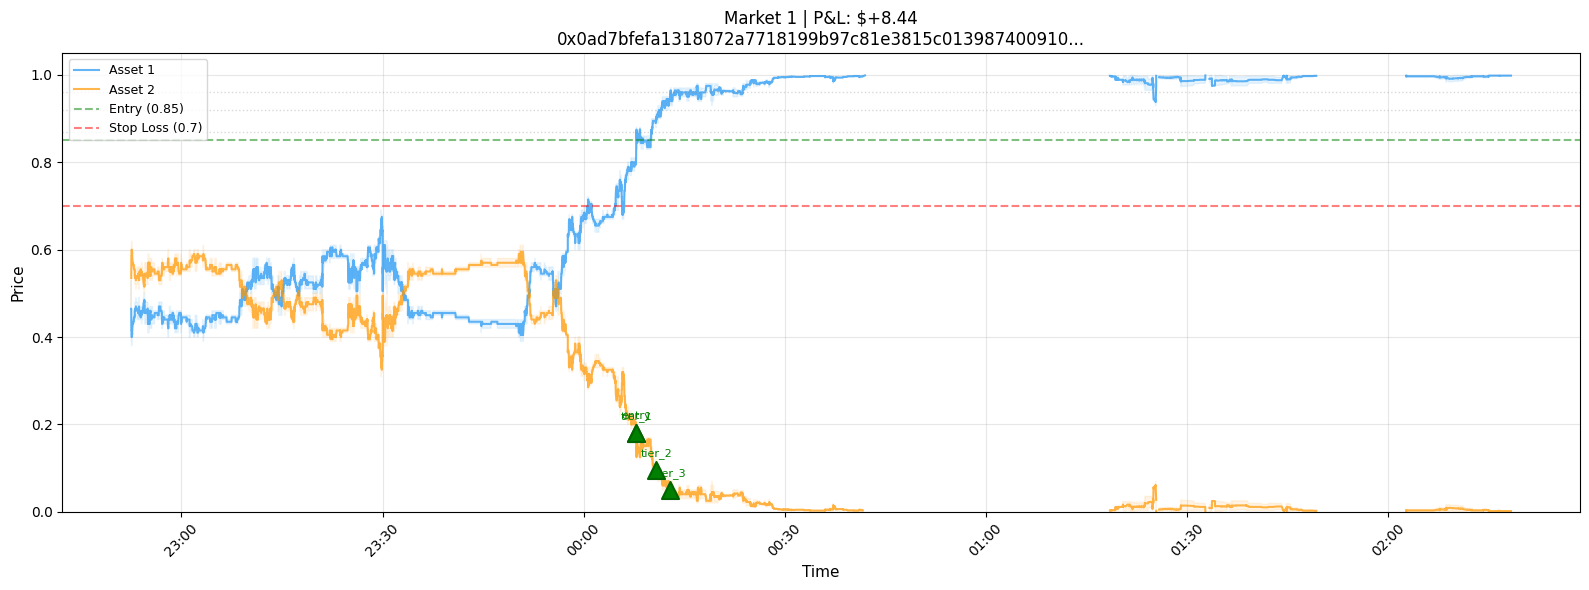

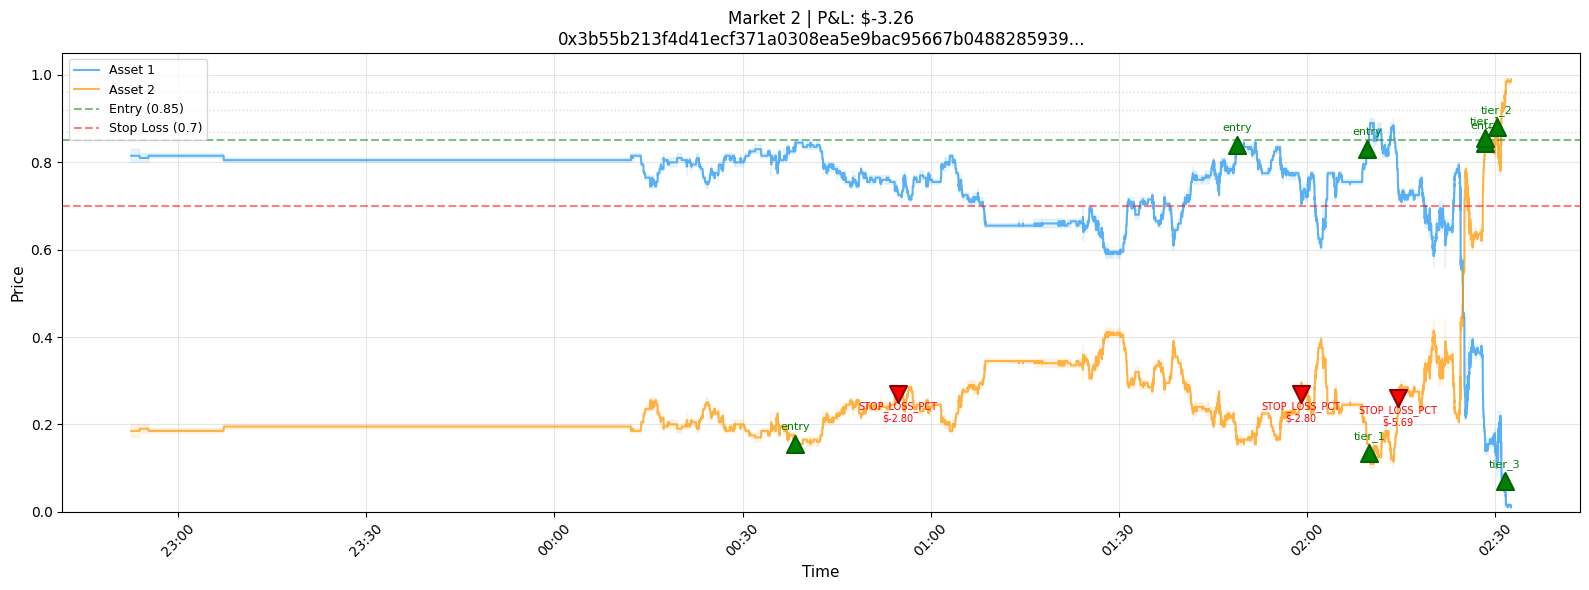

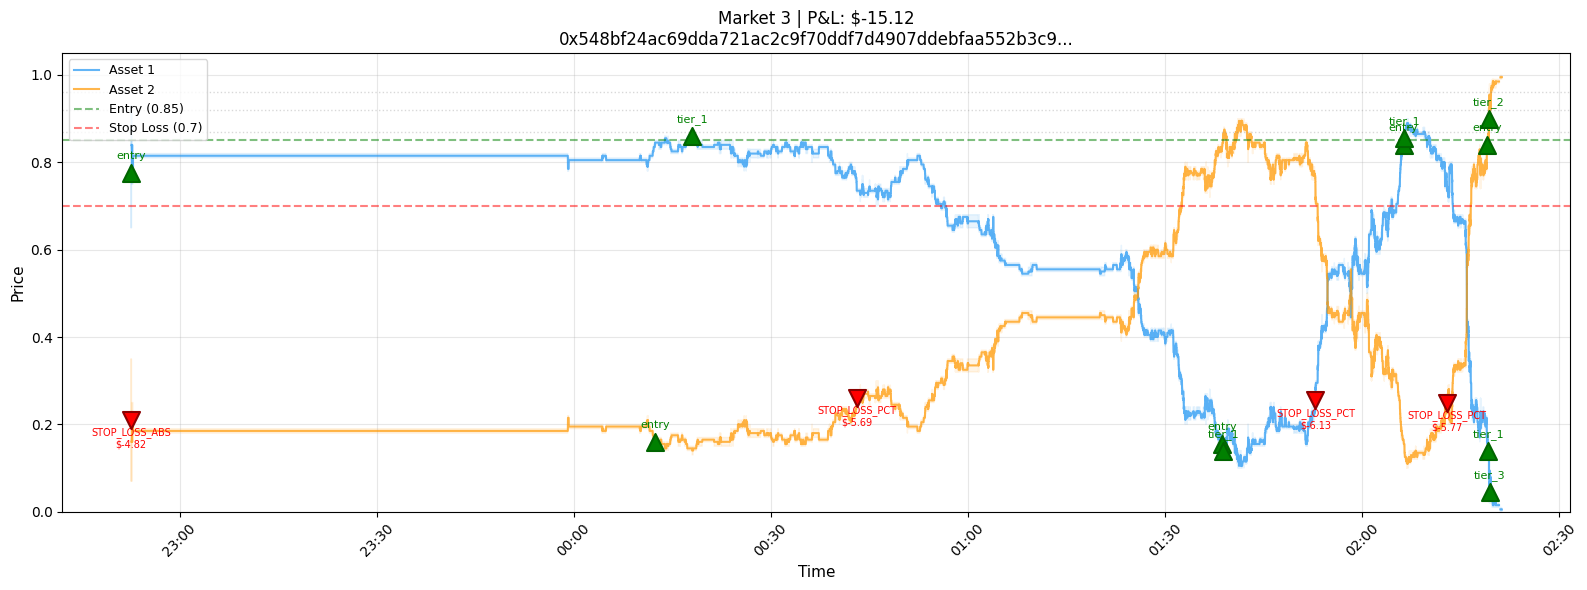

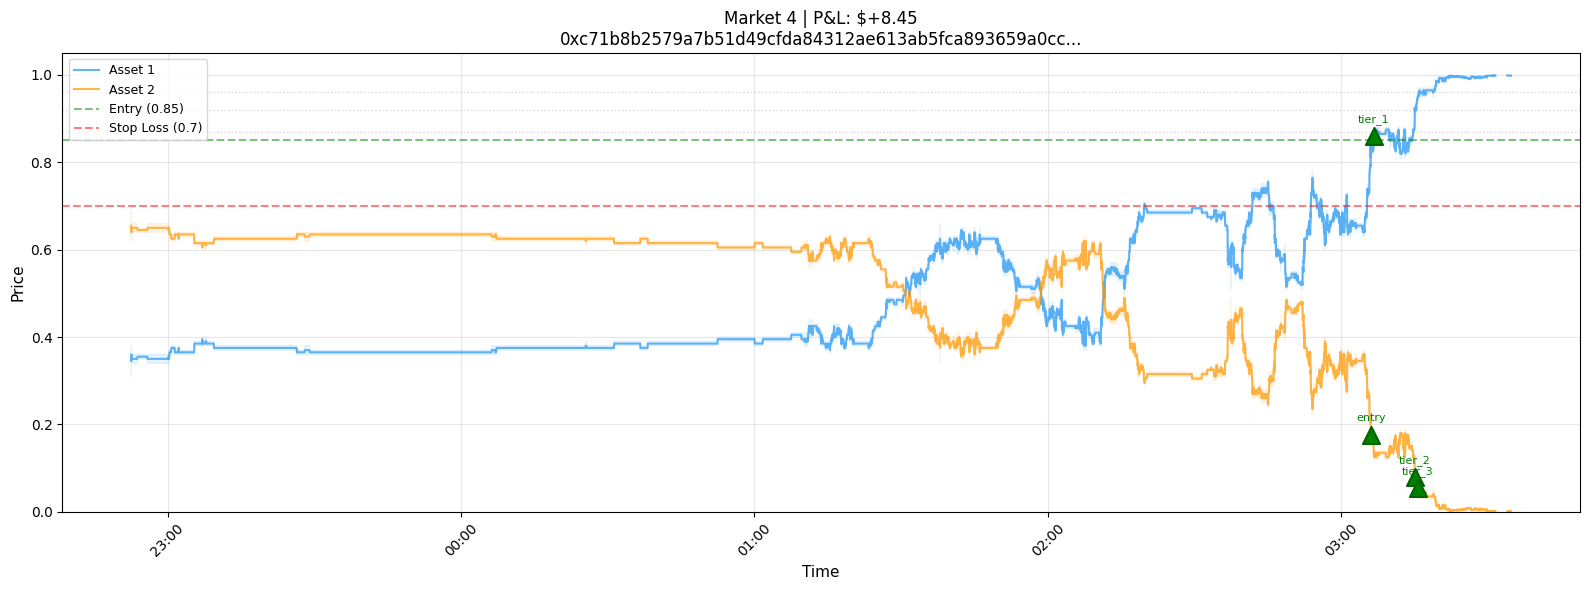

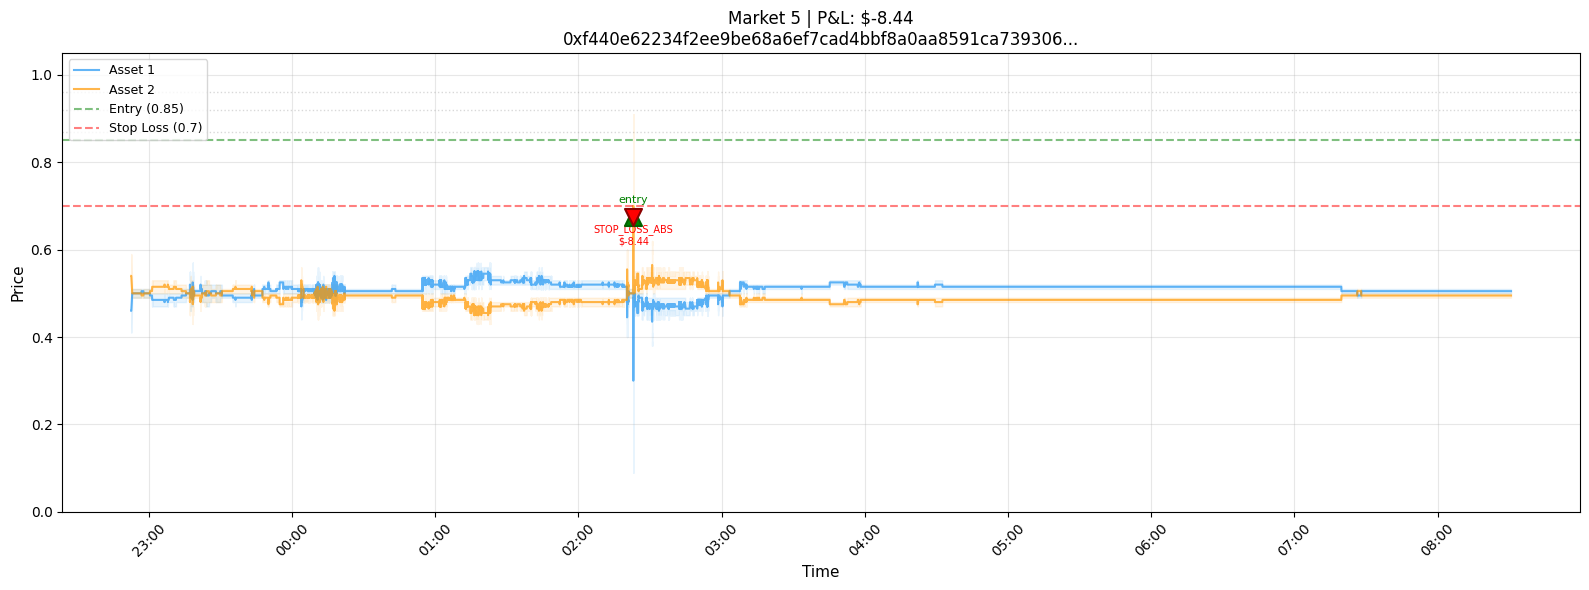

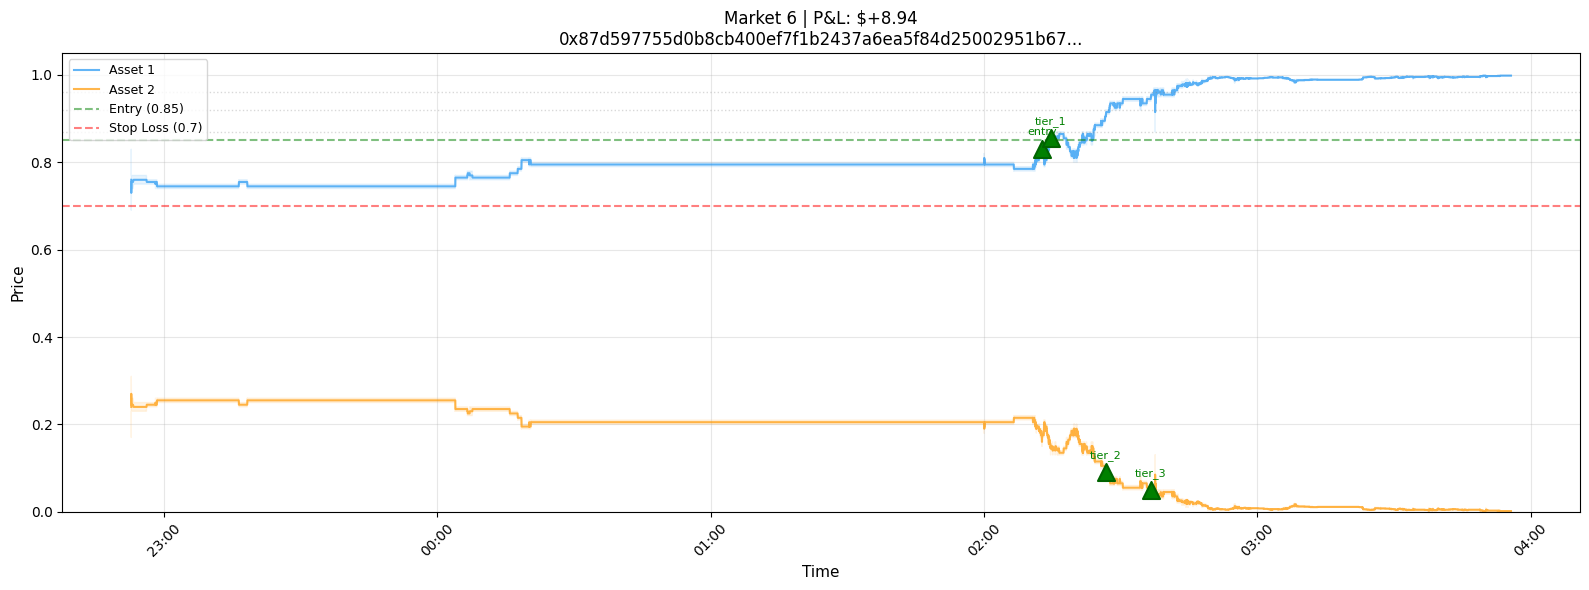

In [70]:
plot_all_markets(df, results)

## 8. Debug Export

Export decision-by-decision Excel files showing every snapshot and the reasoning.

In [73]:
def export_debug(
    df: pd.DataFrame,
    params: Dict = None,
    known_winners: Dict = None,
    initial_capital: float = 500,
    global_tp_pct: float = 0.07,
    selected_markets: List = None,
    resample: str = '5s',
    output_prefix: str = 'debug_market',
    max_rows: int = 50000
) -> Dict:
    """
    Export decision-by-decision Excel files for each market.
    
    Each row shows:
    - Timestamp, prices, orderbook snapshot
    - Action taken (BUY/SELL/HOLD/SKIP)
    - Reason for the decision
    - Current position state, P&L, thresholds
    
    Args:
        df: DataFrame with reconstructed orderbook columns
        params: Strategy parameters
        known_winners: Dict of market_id -> winning asset_id
        initial_capital: Starting capital
        global_tp_pct: Global take profit percentage
        selected_markets: List of market indices or IDs (None = all)
        resample: Resample interval
        output_prefix: Prefix for output files (e.g. 'debug_market' -> 'debug_market_1.xlsx')
        max_rows: Maximum rows per Excel file
    
    Returns:
        Dict with export info
    """
    from openpyxl import Workbook
    from openpyxl.styles import Font, PatternFill, Border, Side, Alignment
    from openpyxl.utils import get_column_letter
    
    params = normalize_params(params)
    
    # Prepare data
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values('datetime')
    df = df[df['ob_best_bid'].notna() & df['ob_best_ask'].notna()].copy()
    
    # Market selection
    all_markets = df['market_id'].unique()
    if selected_markets is not None:
        sel = [all_markets[m] if isinstance(m, int) and m < len(all_markets) else m for m in selected_markets]
        df = df[df['market_id'].isin(sel)]
    
    # Resample
    if resample:
        df['bucket'] = df['datetime'].dt.floor(resample)
        df = df.groupby(['market_id', 'asset_id', 'bucket']).last().reset_index()
        df = df.drop(columns=['datetime']).rename(columns={'bucket': 'datetime'})
        df = df.sort_values('datetime')
    
    print(f"📊 Processing {df['market_id'].nunique()} markets, {len(df):,} rows")
    
    # Strategy params
    ENTRY = params['entry_threshold']
    EXIT_SL = params['exit_stop_loss']
    SL_PCT = params['stop_loss_pct']
    TP_PCT = params['take_profit_pct']
    COOLDOWN = params['cooldown_periods']
    GLOBAL_TP = initial_capital * global_tp_pct
    
    DCA_TIERS = [
        ('entry', ENTRY, params['weight_entry']),
        ('tier_1', params['dca_tier_1'], params['weight_tier_1']),
        ('tier_2', params['dca_tier_2'], params['weight_tier_2']),
        ('tier_3', params['dca_tier_3'], params['weight_tier_3']),
    ]
    
    # Initialize state
    markets = df['market_id'].unique()
    cap_per = initial_capital / len(markets)
    state = {
        m: {'alloc': cap_per, 'cash': cap_per, 'pos': {}, 'active': None, 
            'tiers': set(), 'pnl': 0, 'cooldown': {}}
        for m in markets
    }
    
    # Collect decisions per market
    decisions = {m: [] for m in markets}
    price_cache = {}
    global_tp_hit = False
    
    print("⏳ Simulating decisions...")
    
    for _, row in df.iterrows():
        if global_tp_hit:
            break
        
        aid = row['asset_id']
        mid = row['market_id']
        ts = row['datetime']
        best_bid = row['ob_best_bid']
        best_ask = row['ob_best_ask']
        bids_json = row.get('orderbook_bids', '[]')
        asks_json = row.get('orderbook_asks', '[]')
        
        s = state[mid]
        mid_price = (best_bid + best_ask) / 2
        price_cache[(mid, aid)] = mid_price
        has_pos = aid in s['pos'] and s['pos'][aid]['shares'] > 0
        
        # Format orderbook preview
        bids_list = parse_orderbook_levels(bids_json)[:5]
        asks_list = parse_orderbook_levels(asks_json)[:5]
        ob_bids_str = ' '.join([f"{b['price']:.2f}x{b['size']:.0f}" for b in bids_list])
        ob_asks_str = ' '.join([f"{a['price']:.2f}x{a['size']:.0f}" for a in asks_list])
        
        # Build decision record
        dec = {
            'time': ts,
            'asset': str(aid)[-12:],
            'mid': round(mid_price, 4),
            'bid': round(best_bid, 4),
            'ask': round(best_ask, 4),
            'ob_bids': ob_bids_str[:40],
            'ob_asks': ob_asks_str[:40],
            'action': 'HOLD',
            'reason': '',
            'details': '',
            'has_pos': 'Y' if has_pos else '',
            'shares': '',
            'avg_entry': '',
            'cost_basis': '',
            'sl_price': '',
            'tp_price': '',
            'cash': round(s['cash'], 2),
            'tiers_done': ','.join(sorted(s['tiers'])),
            'unrealized': '',
            'total_pnl': '',
            'cooldown': '',
        }
        
        # Position info
        if has_pos:
            p = s['pos'][aid]
            avg = p['cost'] / p['shares']
            dec['shares'] = round(p['shares'], 2)
            dec['avg_entry'] = round(avg, 4)
            dec['cost_basis'] = round(p['cost'], 2)
            dec['sl_price'] = round(avg * (1 - SL_PCT), 4)
            dec['tp_price'] = round(avg * (1 + TP_PCT), 4)
            dec['unrealized'] = round(p['shares'] * mid_price - p['cost'], 2)
        
        # Cooldown check
        in_cooldown = aid in s['cooldown'] and ts < s['cooldown'][aid]
        if in_cooldown:
            dec['cooldown'] = 'Y'
        
        # Total P&L
        total_pnl = sum(st['pnl'] for st in state.values())
        total_pnl += sum(
            price_cache.get((m, a), 0) * p['shares'] - p['cost']
            for m, st in state.items() for a, p in st['pos'].items() if p['shares'] > 0
        )
        dec['total_pnl'] = round(total_pnl, 2)
        
        # Global TP check
        if total_pnl >= GLOBAL_TP:
            dec['action'] = 'GLOBAL_TP'
            dec['reason'] = 'Global take profit hit'
            dec['details'] = f'${total_pnl:.2f} >= ${GLOBAL_TP:.2f}'
            global_tp_hit = True
            decisions[mid].append(dec)
            continue
        
        # EXIT LOGIC
        if has_pos:
            p = s['pos'][aid]
            avg = p['cost'] / p['shares']
            
            if best_bid < EXIT_SL:
                dec['action'] = 'SELL'
                dec['reason'] = 'STOP_LOSS_ABS'
                dec['details'] = f'bid {best_bid:.4f} < {EXIT_SL}'
                sold, proceeds, _ = execute_sell(bids_json, p['shares'])
                if sold > 0:
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds
                    s['pos'][aid] = {'shares': 0, 'cost': 0}
                    s['active'], s['tiers'] = None, set()
                    s['cooldown'][aid] = ts + pd.Timedelta(seconds=30 * COOLDOWN)
                    dec['details'] += f' | sold {sold:.1f} for ${proceeds:.2f} | PnL ${pnl:+.2f}'
                decisions[mid].append(dec)
                continue
                
            elif best_bid < avg * (1 - SL_PCT):
                dec['action'] = 'SELL'
                dec['reason'] = 'STOP_LOSS_PCT'
                dec['details'] = f'bid {best_bid:.4f} < avg*{1-SL_PCT:.2f} = {avg*(1-SL_PCT):.4f}'
                sold, proceeds, _ = execute_sell(bids_json, p['shares'])
                if sold > 0:
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds
                    s['pos'][aid] = {'shares': 0, 'cost': 0}
                    s['active'], s['tiers'] = None, set()
                    s['cooldown'][aid] = ts + pd.Timedelta(seconds=30 * COOLDOWN)
                    dec['details'] += f' | PnL ${pnl:+.2f}'
                decisions[mid].append(dec)
                continue
                
            elif best_bid >= avg * (1 + TP_PCT):
                dec['action'] = 'SELL'
                dec['reason'] = 'TAKE_PROFIT'
                dec['details'] = f'bid {best_bid:.4f} >= avg*{1+TP_PCT:.2f} = {avg*(1+TP_PCT):.4f}'
                sold, proceeds, _ = execute_sell(bids_json, p['shares'])
                if sold > 0:
                    pnl = proceeds - p['cost']
                    s['pnl'] += pnl
                    s['cash'] += proceeds
                    s['pos'][aid] = {'shares': 0, 'cost': 0}
                    s['active'], s['tiers'] = None, set()
                    s['cooldown'][aid] = ts + pd.Timedelta(seconds=30 * COOLDOWN)
                    dec['details'] += f' | PnL ${pnl:+.2f}'
                decisions[mid].append(dec)
                continue
            else:
                dec['reason'] = 'holding position'
                dec['details'] = f'bid {best_bid:.4f} between SL {avg*(1-SL_PCT):.4f} and TP {avg*(1+TP_PCT):.4f}'
        
        # COOLDOWN CHECK
        if in_cooldown:
            dec['action'] = 'SKIP'
            dec['reason'] = 'cooldown'
            dec['details'] = f'until {s["cooldown"][aid].strftime("%H:%M:%S")}'
            decisions[mid].append(dec)
            continue
        
        # Clear expired cooldown
        if aid in s['cooldown'] and ts >= s['cooldown'][aid]:
            del s['cooldown'][aid]
        
        # ENTRY/DCA LOGIC
        if best_ask >= ENTRY:
            # Check if this is the active asset or can become active
            if s['active'] is None:
                s['active'] = aid
            
            if s['active'] == aid:
                # Try each tier
                bought = False
                for tier, thresh, weight in DCA_TIERS:
                    if tier in s['tiers']:
                        continue
                    if best_ask < thresh:
                        dec['action'] = 'SKIP'
                        dec['reason'] = f'below {tier}'
                        dec['details'] = f'ask {best_ask:.4f} < {thresh}'
                        break
                    
                    amt = min(s['alloc'] * weight, s['cash'])
                    if amt <= 1:
                        dec['action'] = 'SKIP'
                        dec['reason'] = f'insufficient cash for {tier}'
                        dec['details'] = f'need ${s["alloc"]*weight:.2f}, have ${s["cash"]:.2f}'
                        break
                    
                    shares, cost, avg_p = execute_buy(asks_json, amt)
                    if shares > 0:
                        if aid not in s['pos']:
                            s['pos'][aid] = {'shares': 0, 'cost': 0}
                        s['pos'][aid]['shares'] += shares
                        s['pos'][aid]['cost'] += cost
                        s['cash'] -= cost
                        s['tiers'].add(tier)
                        
                        dec['action'] = 'BUY'
                        dec['reason'] = tier.upper()
                        dec['details'] = f'{shares:.2f} shares @ ${avg_p:.4f} = ${cost:.2f}'
                        bought = True
                        break
                    else:
                        dec['action'] = 'SKIP'
                        dec['reason'] = f'no liquidity for {tier}'
                        dec['details'] = 'orderbook empty or insufficient'
                        break
                
                if not bought and dec['action'] == 'HOLD':
                    if len(s['tiers']) == 4:
                        dec['action'] = 'SKIP'
                        dec['reason'] = 'all tiers filled'
                        dec['details'] = 'entry, tier_1, tier_2, tier_3 done'
            else:
                dec['action'] = 'SKIP'
                dec['reason'] = 'wrong asset'
                dec['details'] = f'active asset is different'
        else:
            if not has_pos:
                dec['action'] = 'SKIP'
                dec['reason'] = 'below entry'
                dec['details'] = f'ask {best_ask:.4f} < {ENTRY}'
        
        decisions[mid].append(dec)
    
    print(f"✅ Generated {sum(len(d) for d in decisions.values()):,} decision records")
    
    # Export to Excel files
    print(f"\n📝 Exporting Excel files...")
    
    # Styles
    header_font = Font(bold=True, color='FFFFFF')
    header_fill = PatternFill(start_color='4472C4', end_color='4472C4', fill_type='solid')
    buy_fill = PatternFill(start_color='C6EFCE', end_color='C6EFCE', fill_type='solid')
    sell_fill = PatternFill(start_color='FFC7CE', end_color='FFC7CE', fill_type='solid')
    skip_fill = PatternFill(start_color='FFFFCC', end_color='FFFFCC', fill_type='solid')
    hold_fill = PatternFill(start_color='E0E0E0', end_color='E0E0E0', fill_type='solid')
    border = Border(
        left=Side(style='thin'), right=Side(style='thin'),
        top=Side(style='thin'), bottom=Side(style='thin')
    )
    
    files_created = []
    
    for mi, (market_id, market_decisions) in enumerate(decisions.items()):
        if not market_decisions:
            continue
        
        filename = f'{output_prefix}_{mi+1}.xlsx'
        wb = Workbook()
        ws = wb.active
        ws.title = 'Decisions'
        
        # Headers
        headers = ['Time', 'Asset', 'Mid', 'Bid', 'Ask', 'OB Bids', 'OB Asks',
                   'Action', 'Reason', 'Details', 'Pos', 'Shares', 'AvgEntry', 
                   'CostBasis', 'SL', 'TP', 'Cash', 'Tiers', 'Unrealized', 'TotalPnL', 'CD']
        
        for c, h in enumerate(headers, 1):
            cell = ws.cell(row=1, column=c, value=h)
            cell.font = header_font
            cell.fill = header_fill
            cell.border = border
            cell.alignment = Alignment(horizontal='center')
        
        # Freeze header row
        ws.freeze_panes = 'A2'
        
        # Data rows
        for ri, dec in enumerate(market_decisions[:max_rows], 2):
            time_str = dec['time'].strftime('%H:%M:%S') if hasattr(dec['time'], 'strftime') else str(dec['time'])
            
            values = [
                time_str,
                dec['asset'],
                dec['mid'],
                dec['bid'],
                dec['ask'],
                dec['ob_bids'],
                dec['ob_asks'],
                dec['action'],
                dec['reason'],
                dec['details'][:60] if dec['details'] else '',
                dec['has_pos'],
                dec['shares'],
                dec['avg_entry'],
                dec['cost_basis'],
                dec['sl_price'],
                dec['tp_price'],
                dec['cash'],
                dec['tiers_done'],
                dec['unrealized'],
                dec['total_pnl'],
                dec['cooldown'],
            ]
            
            # Determine row color based on action
            action = dec['action']
            if action == 'BUY':
                row_fill = buy_fill
            elif action == 'SELL' or action == 'GLOBAL_TP':
                row_fill = sell_fill
            elif action == 'SKIP':
                row_fill = skip_fill
            else:
                row_fill = hold_fill
            
            for c, v in enumerate(values, 1):
                cell = ws.cell(row=ri, column=c, value=v)
                cell.border = border
                cell.fill = row_fill
        
        # Column widths
        widths = [9, 14, 7, 7, 7, 30, 30, 10, 18, 50, 4, 8, 9, 9, 9, 9, 8, 20, 10, 10, 4]
        for c, w in enumerate(widths, 1):
            ws.column_dimensions[get_column_letter(c)].width = w
        
        # Add summary sheet
        ws_summary = wb.create_sheet('Summary')
        summary_data = [
            ['Market ID', market_id],
            ['Total Decisions', len(market_decisions)],
            ['BUY actions', sum(1 for d in market_decisions if d['action'] == 'BUY')],
            ['SELL actions', sum(1 for d in market_decisions if d['action'] == 'SELL')],
            ['SKIP actions', sum(1 for d in market_decisions if d['action'] == 'SKIP')],
            ['HOLD actions', sum(1 for d in market_decisions if d['action'] == 'HOLD')],
            [''],
            ['Parameters'],
            ['Entry Threshold', ENTRY],
            ['Exit Stop Loss', EXIT_SL],
            ['Stop Loss %', SL_PCT],
            ['Take Profit %', TP_PCT],
            ['Cooldown Periods', COOLDOWN],
            ['DCA Tier 1', params['dca_tier_1']],
            ['DCA Tier 2', params['dca_tier_2']],
            ['DCA Tier 3', params['dca_tier_3']],
        ]
        for r, row_data in enumerate(summary_data, 1):
            for c, val in enumerate(row_data, 1):
                ws_summary.cell(row=r, column=c, value=val)
        ws_summary.column_dimensions['A'].width = 20
        ws_summary.column_dimensions['B'].width = 60
        
        wb.save(filename)
        files_created.append(filename)
        print(f"   ✅ {filename} ({len(market_decisions):,} rows)")
    
    print(f"\n✅ Created {len(files_created)} Excel files")
    
    return {
        'files': files_created,
        'total_decisions': sum(len(d) for d in decisions.values()),
    }


print("✅ Debug export ready")
print("   export_debug(df, params=my_params, known_winners=known_winners_25jan)")
print("   export_debug(df, params=my_params, selected_markets=[0], output_prefix='debug')")

✅ Debug export ready
   export_debug(df, params=my_params, known_winners=known_winners_25jan)
   export_debug(df, params=my_params, selected_markets=[0], output_prefix='debug')


In [74]:
export_debug(df, params=my_params, known_winners=known_winners_25jan)

📊 Processing 6 markets, 39,608 rows
⏳ Simulating decisions...
✅ Generated 39,608 decision records

📝 Exporting Excel files...
   ✅ debug_market_1.xlsx (3,086 rows)
   ✅ debug_market_2.xlsx (5,206 rows)
   ✅ debug_market_3.xlsx (4,972 rows)
   ✅ debug_market_4.xlsx (6,108 rows)
   ✅ debug_market_5.xlsx (13,746 rows)
   ✅ debug_market_6.xlsx (6,490 rows)

✅ Created 6 Excel files


{'files': ['debug_market_1.xlsx',
  'debug_market_2.xlsx',
  'debug_market_3.xlsx',
  'debug_market_4.xlsx',
  'debug_market_5.xlsx',
  'debug_market_6.xlsx'],
 'total_decisions': 39608}

## 9. Optuna Optimization

In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


def run_optuna(
    df: pd.DataFrame,
    known_winners: Dict,
    n_trials: int = 100,
    initial_capital: float = 500,
    global_tp_pct: float = 0.07
):
    """Optimize parameters with Optuna."""
    
    def objective(trial):
        params = {
            'entry_threshold': trial.suggest_float('entry_threshold', 0.60, 0.85),
            'exit_stop_loss': trial.suggest_float('exit_stop_loss', 0.40, 0.70),
            'stop_loss_pct': trial.suggest_float('stop_loss_pct', 0.08, 0.20),
            'take_profit_pct': trial.suggest_float('take_profit_pct', 0.10, 0.30),
            'cooldown_periods': trial.suggest_int('cooldown_periods', 5, 20),
            'dca_tier_1': trial.suggest_float('dca_tier_1', 0.70, 0.85),
            'dca_tier_2': trial.suggest_float('dca_tier_2', 0.80, 0.92),
            'dca_tier_3': trial.suggest_float('dca_tier_3', 0.88, 0.97),
            'weight_entry': trial.suggest_float('weight_entry', 0.10, 0.25),
            'weight_tier_1': trial.suggest_float('weight_tier_1', 0.15, 0.30),
            'weight_tier_2': trial.suggest_float('weight_tier_2', 0.20, 0.35),
            'weight_tier_3': trial.suggest_float('weight_tier_3', 0.25, 0.40),
        }
        
        # Ensure tier ordering
        if not (params['entry_threshold'] < params['dca_tier_1'] < params['dca_tier_2'] < params['dca_tier_3']):
            return -1.0
        
        try:
            res = run_backtest(df, params=params, known_winners=known_winners,
                              initial_capital=initial_capital, global_tp_pct=global_tp_pct, verbose=False)
            return res['total_return']
        except:
            return -1.0
    
    print(f"🚀 Running {n_trials} trials...")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    
    print(f"\n🏆 Best return: {study.best_value*100:.2f}%")
    print("\nBest params:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
    
    return study, study.best_params


print("✅ Optuna ready")

In [ ]:
# Run optimization:
# study, best_params = run_optuna(df, known_winners_25jan, n_trials=50)